In [76]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import random
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

## Load in the Data and Examine

In [77]:
# TestSample data
app_data = pd.read_csv('Data/testSamples.csv')
print('Clients data shape: ', app_data.shape)
app_data.head()

Clients data shape:  (59721, 2)


,sample_id,test_group
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1


### Examine the Distribution of the test_group Column

In [78]:
app_data['test_group'].value_counts()

0    44886
1    14835
Name: test_group, dtype: int64

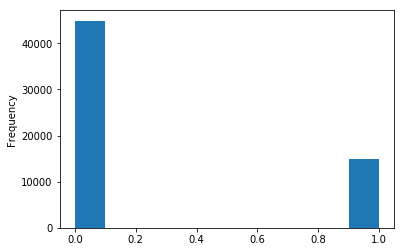

In [79]:
app_data['test_group'].astype(int).plot.hist()

From this information, we see this is an imbalanced class problem ( with a raport of  1:3). There are far more clients who can cancel using a web form (control group) than those who can only cancel by calling in (test group). With some sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

## Aproximate probability distribution between the test group and the control group


The probability distribution between two variables (events) is called Joint Probability distribution. Since the data contained into control and test group is discrete, we can calculate  their individual probability distribution function as the probability of each event occuring. One individual probability distribution function is as well the conditional probability  of the other one.  


__The probability distrbution function control group :__

In [80]:
control=44886 # clients who can cancel using a web form
TOTAL=59721 #total number of clients
proba_control=control/TOTAL #probability distribution of control group (PDF)
proba_control


0.751594916361079

__The probability distrbution function for test group :__

In [81]:
test=14835 #number of clients who can only cancel by calling in
TOTAL=59721 #total number of clients
proba_test=test/TOTAL #probability distribution of test group (PFD)
proba_test

0.24840508363892097

Or can be cal calculated as the probability distribution of control group substracted from 1.0.

In [82]:
proba_test=1-proba_control
proba_test

0.248405083638921

__Since the group in which the sample was placed was a random and biased event (unequal sample sized), the joint probability density function is the product of the two marginals (conditional) probability distributions__ [an example of biased coin flip](http://jim-stone.staff.shef.ac.uk/BookBayes2012/bookbayesch01WithPython.pdf):

In [83]:
joint_proba=proba_test*proba_control
joint_proba

0.18669999806126167

### Simulation on flip of biased coin for sanity check

In [84]:
def flip(p):
    return 'H' if random.random() < p else 'T'

In [85]:
N = 59721 #total number
flips = [flip(0.248) for i in range(N)] #probability of 0.248 to flip 
float(flips.count('H'))/N

0.24614457226101372

In [86]:
# Transactions  data
transactions = pd.read_csv('Data/transData.csv')
print('Transations data shape: ', transactions.shape)
transactions.head()

Transations data shape:  (7430, 4)


,transaction_id,sample_id,transaction_type,transaction_amount
0,52346326,11,REBILL,24.95
1,52346327,11,REBILL,24.95
2,52346328,32,REBILL,29.95
3,52346329,32,REBILL,29.95
4,52346330,32,REBILL,29.95


### Data Types and Missing Values

In [87]:
# See the column data types and non-missing values
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7430 entries, 0 to 7429
Data columns (total 4 columns):
transaction_id        7430 non-null int64
sample_id             7430 non-null int64
transaction_type      7430 non-null object
transaction_amount    7430 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 232.3+ KB


In [88]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

In [89]:
# Missing values statistics
missing_values = missing_values_table(transactions)
missing_values.head()

Your selected dataframe has 4 columns.
There are 0 columns that have missing values.


AttributeError: 'NoneType' object has no attribute 'head'

In [90]:
## add the data contained in transaction file to the TestSample data
app_data= app_data.merge(transactions, on = 'sample_id', how = 'left')

In [91]:
app_data.dtypes

sample_id               int64
test_group              int64
transaction_id        float64
transaction_type       object
transaction_amount    float64
dtype: object

In [92]:
# one-hot encoding of categorical variables
app_data = pd.get_dummies(app_data)

In [93]:
print('Training Features shape: ', app_data.shape)

Training Features shape:  (64437, 7)


In [94]:
app_data.head()

,sample_id,test_group,transaction_id,transaction_amount,transaction_type_CHARGEBACK,transaction_type_REBILL,transaction_type_REFUND
0,1,0,NaN,NaN,0,0,0
1,2,1,NaN,NaN,0,0,0
2,3,0,NaN,NaN,0,0,0
3,4,1,NaN,NaN,0,0,0
4,5,1,NaN,NaN,0,0,0


In [95]:
app_data.dropna(subset = ['transaction_id', 'transaction_type_CHARGEBACK', 'transaction_type_REBILL', 'transaction_type_REFUND', 'transaction_amount'])

,sample_id,test_group,transaction_id,transaction_amount,transaction_type_CHARGEBACK,transaction_type_REBILL,transaction_type_REFUND
10,11,1,52346326.0,24.95,0,1,0
11,11,1,52346327.0,24.95,0,1,0
32,32,1,52346328.0,29.95,0,1,0
33,32,1,52346329.0,29.95,0,1,0
34,32,1,52346330.0,29.95,0,1,0
35,32,1,52346331.0,29.95,0,1,0
106,103,0,52346332.0,19.95,0,1,0
107,103,0,52346333.0,19.95,0,1,0
108,103,0,52346334.0,19.95,0,1,0
109,103,0,52346335.0,19.95,0,1,0


In [96]:
#app_data = app_data.replace('NaN', 0)

## Analizing the test groups with respect to Rebill Transactions

In [98]:
app_data.groupby(['test_group', 'transaction_type_REBILL']).count()

sample_id  transaction_id  \
test_group transaction_type_REBILL                              
0          0                            44101             294   
           1                             3756            3756   
1          0                            13375             175   
           1                             3205            3205   

                                    transaction_amount  \
test_group transaction_type_REBILL                       
0          0                                       294   
           1                                      3756   
1          0                                       175   
           1                                      3205   

                                    transaction_type_CHARGEBACK  \
test_group transaction_type_REBILL                                
0          0                                              44101   
           1                                               3756   
1          0                                              13375   
           1                                               3205   

                                    transaction_type_REFUND  
test_group transaction_type_REBILL                           
0          0                                          44101  
           1                                           3756  
1          0                                          13375  
           1                                           3205

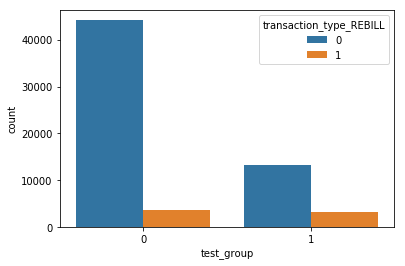

In [99]:

ax = sns.countplot(x="test_group", hue="transaction_type_REBILL", data=app_data)

As per the the table and  plot from above,  the number of test group users (1) that have generated a Rebill Transaction is 3205 and represents as percentage __19.33%__, while the numberof control group users(0) that have generated a Rebill Transaction is 3756,as percentage:__7.85%__. 
As the numbers say (but not necessary while using a prediction model), __an user that must call-in to cancel (1=test group) IS  more likely to generate at least 1 addition REBILL__.

## Analizing the test groups with respect to the Transactions amount

In [100]:
app_data.groupby(['test_group', 'transaction_amount']).count()

sample_id  transaction_id  \
test_group transaction_amount                              
0          -32.95                     90              90   
           -24.95                     97              97   
           -19.95                    107             107   
            19.95                   1189            1189   
            24.95                   1368            1368   
            32.95                   1199            1199   
1          -39.95                     50              50   
           -29.95                     64              64   
           -24.95                     61              61   
            24.95                   1124            1124   
            29.95                   1031            1031   
            39.95                   1050            1050   

                               transaction_type_CHARGEBACK  \
test_group transaction_amount                                
0          -32.95                                       90   
           -24.95                                       97   
           -19.95                                      107   
            19.95                                     1189   
            24.95                                     1368   
            32.95                                     1199   
1          -39.95                                       50   
           -29.95                                       64   
           -24.95                                       61   
            24.95                                     1124   
            29.95                                     1031   
            39.95                                     1050   

                               transaction_type_REBILL  \
test_group transaction_amount                            
0          -32.95                                   90   
           -24.95                                   97   
           -19.95                                  107   
            19.95                                 1189   
            24.95                                 1368   
            32.95                                 1199   
1          -39.95                                   50   
           -29.95                                   64   
           -24.95                                   61   
            24.95                                 1124   
            29.95                                 1031   
            39.95                                 1050   

                               transaction_type_REFUND  
test_group transaction_amount                           
0          -32.95                                   90  
           -24.95                                   97  
           -19.95                                  107  
            19.95                                 1189  
            24.95                                 1368  
            32.95                                 1199  
1          -39.95                                   50  
           -29.95                                   64  
           -24.95                                   61  
            24.95                                 1124  
            29.95                                 1031  
            39.95                                 1050

In [101]:
#the mean value in transactions corresponding  1=test group
app_data.loc[app_data['test_group'] == 1, 'transaction_amount'].mean()

28.23476331360791

In [102]:
#the mean value in transactions corresponding  0= control group
app_data.loc[app_data['test_group'] == 0, 'transaction_amount'].mean()

22.182444444443032

In [103]:
#Sum values in transactions corresponding  1=test group
app_data.groupby('test_group')['transaction_amount'].sum()[1]

95433.49999999473

In [104]:
#Sum values in transactions corresponding   0= control group
app_data.groupby('test_group')['transaction_amount'].sum()[0]

89838.89999999428

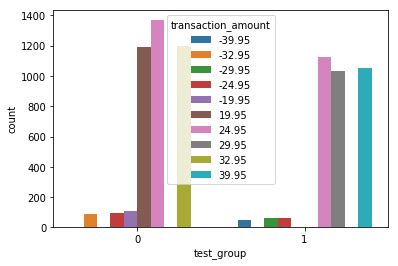

In [105]:
import seaborn as sns
ax = sns.countplot(x="test_group", hue="transaction_amount", data=app_data)

As per the  plot from above and stats, there is a sligthly difference between the revenue values brought by the test group users (1=95433.49) and one brought by the numberof control group users(0=89838.89). 
As the numbers say , __an user that must call-in to cancel (1=test group) IS MORE LIKELY to generate more revenues__.

## Analizing the test groups with respect to CHARGEBACK/Refund Transactions

In [106]:
app_data.groupby(['test_group', 'transaction_type_CHARGEBACK']).count()

sample_id  transaction_id  \
test_group transaction_type_CHARGEBACK                              
0          0                                47751            3944   
           1                                  106             106   
1          0                                16523            3323   
           1                                   57              57   

                                        transaction_amount  \
test_group transaction_type_CHARGEBACK                       
0          0                                          3944   
           1                                           106   
1          0                                          3323   
           1                                            57   

                                        transaction_type_REBILL  \
test_group transaction_type_CHARGEBACK                            
0          0                                              47751   
           1                                                106   
1          0                                              16523   
           1                                                 57   

                                        transaction_type_REFUND  
test_group transaction_type_CHARGEBACK                           
0          0                                              47751  
           1                                                106  
1          0                                              16523  
           1                                                 57

In [107]:
app_data.groupby(['test_group', 'transaction_type_REFUND']).count()

sample_id  transaction_id  \
test_group transaction_type_REFUND                              
0          0                            47669            3862   
           1                              188             188   
1          0                            16462            3262   
           1                              118             118   

                                    transaction_amount  \
test_group transaction_type_REFUND                       
0          0                                      3862   
           1                                       188   
1          0                                      3262   
           1                                       118   

                                    transaction_type_CHARGEBACK  \
test_group transaction_type_REFUND                                
0          0                                              47669   
           1                                                188   
1          0                                              16462   
           1                                                118   

                                    transaction_type_REBILL  
test_group transaction_type_REFUND                           
0          0                                          47669  
           1                                            188  
1          0                                          16462  
           1                                            118

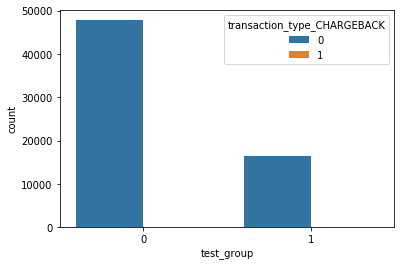

In [108]:
import seaborn as sns
ax = sns.countplot(x="test_group", hue="transaction_type_CHARGEBACK", data=app_data)

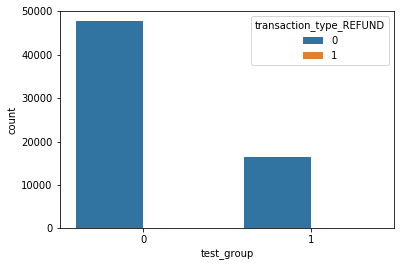

In [109]:
ax = sns.countplot(x="test_group", hue="transaction_type_REFUND", data=app_data)

As per the plot from above and stats, one one hand, the total number of Chargeback transactions done by the test group users (1) is 57 (0.35%), while the control group users(0) performed 106 (0.22%) Chargeback transactions. On the other hand, the total number of Refund transactions done by the test group users (1) is 118 (0.71%), while the control group users(0) performed 188 (0.4%) Refund transactions.
As the numbers say , __an user that must call-in to cancel (1=test group) IS  more likely to produce a higher chargeback rate(CHARGEBACKs/Refund)__.

## __Note__:

Although the experiment produced a  [sample size imbalance](https://janhove.github.io/design/2015/11/02/unequal-sample-sized), instead of using the total number of each type of transaction, I have used the percentage that represented the number within that group.